In [ ]:
#default_exp main

In [ ]:
#export
import os
import pandas as pd
import numpy as np
import transformers

from fastai.text.all import *

from Hasoc import utils
from Hasoc import model

In [ ]:
#export
SEED = 42
utils.seed_everything(seed=SEED)

In [ ]:
#export 
MODEL_NAME = 'bert-base-uncased'
MAX_SEQ_LEN = 72
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
df = pd.read_csv(os.path.join('..', 'data', 'fold_df'))

In [ ]:
df.shape

(3708, 7)

In [ ]:
#hide
df.sample(2)

,tweet_id,text,task1,task2,ID,kfold_task1,kfold_task2
1783,1.127040e+18,"RT @theblondeMD: Every time I go on a rant I lose followers but honestly if you’re anti vax, or anti choice I dont want you here anyway 👏🏼…",NOT,NONE,hasoc_2020_en_332,0,2
1929,1.123619e+18,"RT @btsvotingteam: Do you want to see our TOTAL VOTES ACCUMULATED FOR TODAY?\n\nTo unlock\n🔐 11,000 RTs \n🔐 4,000 Replies\nIn just 1 hour... \n\n#…",NOT,NONE,hasoc_2020_en_1328,4,2


In [ ]:
#hide
df['task1'].value_counts()

HOF    1856
NOT    1852
Name: task1, dtype: int64

In [ ]:
#hide
df['task2'].value_counts()

NONE    1852
PRFN    1377
OFFN     321
HATE     158
Name: task2, dtype: int64

In [ ]:
#export
df.tweet_id = df.tweet_id.astype('int').astype('str')

In [ ]:
#export
bert_tokenizer = transformers.BertTokenizer.from_pretrained(
            pretrained_model_name_or_path=MODEL_NAME,
            do_lower_case=True,
            )

In [ ]:
bert_vocab = bert_tokenizer.get_vocab()
bert2fastai_vocab = [k for k, v in sorted(bert_vocab.items(), key=lambda item: item[1])]

In [ ]:
#export 
pad = partial(pad_input_chunk, pad_first=False, pad_idx=bert_tokenizer.pad_token_id, seq_len=MAX_SEQ_LEN)

In [ ]:
#export
custom_tokenizer = Tokenizer.from_df(text_cols='text', tok=utils.HFTokenizer(tokenizer=bert_tokenizer), rules=[])

In [ ]:
#export
tfms = [attrgetter('text'), custom_tokenizer, Numericalize(vocab=bert2fastai_vocab), utils.Add_Special_Cls(tokenizer=bert_tokenizer)]

## Task 1

In [ ]:
fold = 0
splits = IndexSplitter(list(df.query(f'kfold_task1 == {fold}').index))(df)

In [ ]:
#hide
splits

((#2966) [0,1,2,4,5,6,8,9,10,13...], (#742) [3,7,11,12,16,32,33,38,41,45...])

In [ ]:
#export
dsets = Datasets(df, tfms=[tfms, [attrgetter('task1'), Categorize()]], splits=splits, dl_type=SortedDL)

In [ ]:
#export
# splits = RandomSplitter()(df)

In [ ]:
#export
dls_clas = dsets.dataloaders(bs=56, val_bs=144, before_batch=[pad], seq_len=MAX_SEQ_LEN)

In [ ]:
#export
dls_clas.show_batch(max_n=2)

,text,category
0,[CLS] rt @ na ##lu _ for _ you : after na ##lu one of my favourite [UNK] - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - … [SEP],NOT
1,"[CLS] rt @ 780 ##6 ##13 : seo ##k ##jin ##s mom : how can u not see me when im cheering like "" ah ##hh ##h ! ! ! ya ##hh ##h ! ! ! ! ! ! seo ##k ##jin - ah ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ya ##hh ##hh ##h ! ! ! ! ! ! ! ! ! ! "" … [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]",NOT


In [ ]:
#export
modeller = model.HasocModel(out_feat=dsets.c)

In [ ]:
#export
learn = Learner(dls_clas, modeller.to(device), metrics=[accuracy, F1Score(average='macro')], 
                drop_mult=0.3, device=device, loss_func=CrossEntropyLossFlat())

SuggestedLRs(lr_min=0.0001737800776027143, lr_steep=0.0005754399462603033)

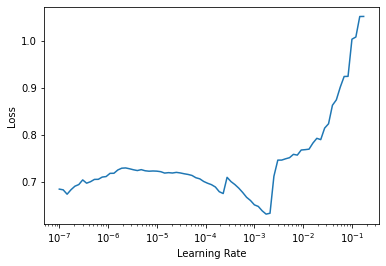

In [ ]:
#export
learn.lr_find()

In [ ]:
#export
lr = 2e-4

# learn.fit_one_cycle(7, lr, moms=(0.8,0.7,0.8), wd=0.1)
learn.fit_one_cycle(7, lr)

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.503764,0.273966,0.907008,0.906994,00:21
1,0.313423,0.253474,0.902965,0.902920,00:22
2,0.217105,0.282782,0.901617,0.901617,00:21
3,0.141862,0.354812,0.893531,0.893236,00:22
4,0.080504,0.387372,0.902965,0.902959,00:22
5,0.042611,0.405715,0.908356,0.908356,00:23
6,0.028835,0.410404,0.900270,0.900243,00:22


In [ ]:
#export
learn.export(os.path.join('models', 'task1.pkl'))
# learn.save((os.path.join('task1')))

## Task2

Try focalloss too

In [ ]:
fold = 0
splits = IndexSplitter(list(df.query(f'kfold_task2 == {fold}').index))(df)

In [ ]:
#export
dsets = Datasets(df, tfms=[tfms, [attrgetter('task2'), Categorize()]], splits=splits, dl_type=SortedDL)

In [ ]:
dsets.categorize.vocab

(#4) ['HATE','NONE','OFFN','PRFN']

In [ ]:
from collections import Counter
count = Counter(df.task2).values()
class_weights = np.array([1/Counter(df.task2)[str(v)] for v in dsets.categorize.vocab])

In [ ]:
class_weights

array([0.00632911, 0.00053996, 0.00311526, 0.00072622])

In [ ]:
#hide
class_weights

array([0.00632911, 0.00053996, 0.00311526, 0.00072622])

In [ ]:
#hide
dsets.train.items['task2'].values[:3]

array(['PRFN', 'PRFN', 'PRFN'], dtype=object)

In [ ]:
#export
weights = class_weights[L(dsets.train).map(lambda x: x[1])]

In [ ]:
#hide
weights[20:30], np.unique(weights)

(array([0.00072622, 0.00072622, 0.00053996, 0.00072622, 0.00072622,
        0.00072622, 0.00053996, 0.00053996, 0.00053996, 0.00072622]),
 array([0.00053996, 0.00072622, 0.00311526, 0.00632911]))

In [ ]:
weights.shape


(2966,)

In [ ]:
def one_hot_embedding(labels, num_classes):
    return torch.eye(num_classes)[labels.data.cpu()]

class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, logits=True, reduce=True, device=device):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduce = reduce
        self.device = device
        self.axis = -1

    def forward(self, inputs, targets):
        targets = one_hot_embedding(targets, inputs.size(-1)).to(self.device)
        if self.logits:
            BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets)
        else:
            BCE_loss = F.binary_cross_entropy(inputs, targets)

        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss

In [ ]:
class FocalLossFlat(BaseLoss):
    "Same as `FocalLoss`, but flattens input and target."
    y_int = True
    @use_kwargs_dict(keep=True, weight=None, ignore_index=-100, reduction='mean')
    def __init__(self, *args, axis=-1, **kwargs): super().__init__(FocalLoss, *args, axis=axis, **kwargs)
    def decodes(self, x):    return x.argmax(dim=self.axis)
    def activation(self, x): return F.softmax(x, dim=self.axis)

In [ ]:
#export
dls_clas = dsets.dataloaders(bs=56, val_bs=144, before_batch=[pad], seq_len=MAX_SEQ_LEN)

# dls_clas = dsets.weighted_dataloaders(wgts=weights, bs=56,val_bs=144, before_batch=[pad], seq_len=MAX_SEQ_LEN)

In [ ]:
#export
dls_clas.show_batch(max_n=2)

,text,category
0,[CLS] rt @ sud ##out ##ats ##uy ##a : eat shit grammar nazis ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! [SEP],OFFN
1,"[CLS] rt @ 780 ##6 ##13 : seo ##k ##jin ##s mom : how can u not see me when im cheering like "" ah ##hh ##h ! ! ! ya ##hh ##h ! ! ! ! ! ! seo ##k ##jin - ah ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ya ##hh ##hh ##h ! ! ! ! ! ! ! ! ! ! "" … [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]",NONE


In [ ]:
#export
modeller = model.HasocModel(out_feat=dsets.c)

In [ ]:
#export
learn = Learner(dls_clas, modeller.to(device), metrics=[accuracy, F1Score(average='macro')], drop_mult=0.3, device=device, loss_func=FocalLossFlat())

In [ ]:
L(modeller.named_parameters())

(#201) [('model.embeddings.word_embeddings.weight', Parameter containing:
tensor([[-0.0102, -0.0615, -0.0265,  ..., -0.0198, -0.0372, -0.0097],
        [-0.0117, -0.0600, -0.0323,  ..., -0.0168, -0.0401, -0.0107],
        [-0.0197, -0.0627, -0.0326,  ..., -0.0165, -0.0420, -0.0032],
        ...,
        [-0.0218, -0.0556, -0.0135,  ..., -0.0043, -0.0151, -0.0249],
        [-0.0462, -0.0565, -0.0019,  ...,  0.0157, -0.0139, -0.0094],
        [ 0.0015, -0.0821, -0.0160,  ..., -0.0081, -0.0474,  0.0752]],
       device='cuda:0', requires_grad=True)),('model.embeddings.position_embeddings.weight', Parameter containing:
tensor([[ 0.0185, -0.0255, -0.0344,  ..., -0.0015, -0.0008,  0.0133],
        [ 0.0076,  0.0006, -0.0191,  ...,  0.0288,  0.0315, -0.0062],
        [-0.0120, -0.0019, -0.0125,  ...,  0.0130,  0.0184, -0.0070],
        ...,
        [ 0.0174,  0.0035, -0.0096,  ...,  0.0030,  0.0004, -0.0269],
        [ 0.0217, -0.0060,  0.0147,  ..., -0.0056, -0.0126, -0.0281],
        [ 0.00

In [ ]:
learn.validate()

(#3) [0.2675606608390808,0.07412398606538773,0.07246539422446721]

SuggestedLRs(lr_min=0.003981071710586548, lr_steep=3.0199516913853586e-05)

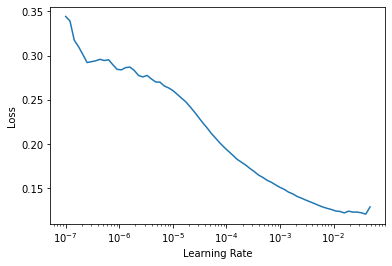

In [ ]:
#export
learn.lr_find()

In [ ]:
#export
lr = 2e-4

# learn.fit_one_cycle(7, lr, moms=(0.8,0.7,0.8), wd=0.1)
learn.fit_one_cycle(7, lr)

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.073996,0.025904,0.776280,0.410963,00:23
1,0.030363,0.014618,0.816712,0.441600,00:23
2,0.015823,0.021170,0.812668,0.458863,00:22
3,0.008902,0.020337,0.799191,0.485091,00:23
4,0.004484,0.022919,0.793801,0.503127,00:23
5,0.002214,0.024975,0.789757,0.516347,00:23
6,0.001172,0.025302,0.788410,0.515206,00:23


In [ ]:
#export
# learn.export(os.path.join('models', 'task2.pkl'))
learn.save(os.path.join('task2.pkl'))

Path('models/task2.pkl.pth')

## interp

In [ ]:
learn.loss

In [ ]:
dls_clas.valid

In [ ]:
learn.get_preds(dl=dls_clas.valid)

(tensor([[1.1006e-04, 9.9971e-01, 8.0556e-05, 9.6281e-05],
         [7.0974e-05, 9.9980e-01, 6.5440e-05, 6.2897e-05],
         [1.2697e-04, 9.9963e-01, 1.3288e-04, 1.0736e-04],
         ...,
         [1.1295e-03, 1.7662e-02, 1.5125e-03, 9.7970e-01],
         [2.9721e-04, 9.9902e-01, 1.9905e-04, 4.8710e-04],
         [5.6341e-03, 1.4437e-03, 2.2125e-02, 9.7080e-01]]),
 tensor([1, 1, 1, 1, 1, 0, 2, 0, 3, 3, 1, 3, 2, 2, 3, 1, 3, 1, 3, 3, 1, 1, 3, 3,
         3, 1, 1, 1, 1, 1, 1, 1, 0, 3, 3, 1, 1, 1, 2, 1, 1, 1, 0, 1, 3, 3, 3, 3,
         3, 3, 1, 2, 1, 3, 1, 3, 2, 3, 1, 3, 1, 3, 1, 1, 3, 3, 1, 1, 1, 0, 0, 3,
         1, 1, 3, 1, 1, 1, 3, 1, 1, 1, 3, 3, 3, 1, 3, 1, 2, 3, 3, 1, 3, 1, 1, 1,
         1, 3, 3, 1, 1, 3, 2, 3, 2, 3, 1, 2, 1, 1, 3, 3, 2, 1, 3, 3, 3, 3, 3, 3,
         1, 1, 2, 1, 3, 3, 3, 3, 3, 1, 1, 2, 3, 3, 3, 1, 1, 1, 0, 3, 1, 1, 1, 1,
         0, 1, 1, 3, 3, 3, 3, 3, 1, 3, 1, 1, 3, 3, 1, 1, 1, 1, 1, 1, 3, 1, 1, 3,
         3, 3, 1, 3, 1, 3, 3, 3, 1, 3, 3, 3, 1, 3, 1, 2, 1, 1, 

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

/usr/local/lib/python3.6/dist-packages/fastprogress/fastprogress.py:74: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


TypeError: __init__() missing 1 required positional argument: 'losses'

In [ ]:
# interp.plot_confusion_matrix()

In [ ]:
learn.predict('What the fuck are you talking. go to hell', with_input=True)

IndexError: list index out of range

In [ ]:
learn.predict("I will chop off your head and kill you")

("(#4) ['PRFN','NONE','HATE','PRFN']",
 tensor([-1.5455, -3.4268,  0.8430, -1.8050]),
 tensor([-1.5455, -3.4268,  0.8430, -1.8050]))